# Imports and preparation

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import nltk
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Transformer model
from transformers import BertModel, BertTokenizer, AutoModel, AutoTokenizer

# Preprocessing
from typing import List
from collections import OrderedDict
from ast import literal_eval
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Stat. tests
from scipy.stats import shapiro, levene
from scipy import stats
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
from torch.nn.functional import cosine_similarity

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Variable:
# The variable we use to determine under which government an intervention
# took place
government = 'Presidential_Split'

In [ ]:
# Model:
model = BertModel.from_pretrained('bert-base-uncased',
           output_hidden_states = True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
pip install scipy

# Connect to drive

We used google drive and google colab to access and process the data.

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

This narrative aims to explore the use of **BERT** to generate word contextualized embeddings to compute politicization score of keywords, and then generalize them to the reports' level.

We are dividing the reports relative to the political administrations they were mainly conducted under (Republican or Democrat) using the *Presidential Split*. This split is based on the three main political bodies of a government: the President, the Senate, and the House of Congress.

The scores of keywords will be evaluated using the Wilcoxon rank-sum test, and the scores of reports will be evaluated using the Spearman test.

This is one out of 4 narratives:

* BERT and *Institutional Split* (1/4)
* BERT and *Presidential Split* (2/4) <--
* RoBERTa and *Institutional Split* (3/4)
* RoBERTa and *Presidential Split* (4/4)


# Data loading

## Politicization dataframe

We load the data and inspect the shape and columns.

In [ ]:
PATH_DF = "/content/drive/MyDrive/MyThesis/df_politicization_2_gov_splits.xlsx"

# we read and convert the 'Projects' sheet into a DataFrame
df_politicization = pd.read_excel(PATH_DF)

# Inspecting the shape
print(f"Shape of df_politicization: {df_politicization.shape}")

Shape of df_politicization: (99, 52)


There are 99 reports and 52 features.

In [ ]:
df_politicization.columns

Index(['Document ID', 'Text', 'Document Type', 'Authoring Organization(s)',
       'Sponsoring Organization(s)', 'Pagination', 'Contract/Grant Number(s)',
       'Country/Region Name', 'Publication Date', 'Year Start', 'Year End',
       'President_Start', 'Senate_Start', 'House_Start', 'PSH_Start',
       'DivGov_Start', 'President_End', 'Senate_End', 'House_End', 'PSH_End',
       'DivGov_End', 'Project_Duration', 'DivGov_ProjectYears',
       'DivGov_FractionProject', 'DemPres_ProjectYears',
       'DemPres_FractionProject', 'DemSen_ProjectYears',
       'DemSen_FractionProject', 'DemHouse_ProjectYears',
       'DemHouse_ProjectFraction', 'DivGov_MajorityProject',
       'DemPres_MajorityProject', 'Month Start', 'Month End',
       'Results Section', 'Results Section Title', 'Results Section Location',
       'Primary Subject', 'USAID Thesaurus Term(s)', 'Tags', 'Notes', 'Length',
       'Word_count', 'Mean_word_length', 'Mean_sent_length', 'lang', 'proba',
       'Text_clean', 'Tex

We select the columns of interest and create a df contianing only these.

In [ ]:
list_features = ['Document ID', 'Text', 'Text_clean', 'President_Start',\
                 'Presidential_Split','USAID Thesaurus Term(s)' ]

df = df_politicization[list_features]

# Inspecting the shape
print(f"Shape of df_politicization once filtered: {df.shape}")

Shape of df_politicization once filtered: (99, 6)


Again it has 99 reports, but we selected only 6 features of interest.

We perform a simple check to know what are the values used in the `government` variable. There are only 2 strings: 'D' corresponds to Democrat, and 'R' to Republican.

In [ ]:
df[government].unique()

array(['D', 'R'], dtype=object)

We preprocess the text for BERT to correctly process the sentences.

In [ ]:
def clean_text(text:str):
    '''
    Returns a string where we lowercased the text, and removed special
    characters and stopwords.

    Parameters:
        text: A string to clean.

    Returns:
        A lowercased text with special characters and stopwords removed.
    '''
    return " ".join(
        word for word in re.sub('[^a-zA-Z0-9-.,;:!?]+', ' ', text.lower()).split()
        if word not in stopwords.words('english')
    )

We apply the `clean_text` function to the text of the reports to standardize the strings.

In [ ]:
df['Text_Processed'] = df['Text'].apply(clean_text)

<ipython-input-12-682bb05a5cac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text_Processed'] = df['Text'].apply(clean_text)


In [ ]:
# we inspect the resulting feature
df[['Text','Text_Processed']].head()

,Text,Text_Processed
0,jhnp2014ohanesian final progress report june ...,jhnp2014ohanesian final progress report june 2...
1,f i n a l r e p o r t 20092015 the usaid tb pr...,f n l r e p r 20092015 usaid tb program south ...
2,"1 usaidea flexible family planning, reproducti...","1 usaidea flexible family planning, reproducti..."
3,1 table of contents letter from the director ...,1 table contents letter director national aids...
4,zimbabwe final country report march 2007 this ...,zimbabwe final country report march 2007 publi...


### 'USAID Thesaurus Term(s)' preprocessing

We want to use the `USAID Thesaurus Terms(s)`to compute the 'silver score' at the document level. For this reason we must preprocess it similarly to the reports.

In [ ]:
df['USAID Thesaurus Term(s)'].head()

0    Curriculum; Female empowerment; Governance; He...
1    HIV/AIDS; Children; Communities; Decentralizat...
2    Communities; Crimes; Demographic surveys; Heal...
3    People living with AIDS (PLWA); Community mobi...
4    HIV/AIDS; Arts; Demographic surveys; Disease p...
Name: USAID Thesaurus Term(s), dtype: object

We replace the semicolon-separated string by a list of terms.

In [ ]:
df['USAID_Thesaurus_Term(s)'] = df['USAID Thesaurus Term(s)'].str.split('; ')

print(df['USAID_Thesaurus_Term(s)'].head())

0    [Curriculum, Female empowerment, Governance, H...
1    [HIV/AIDS, Children, Communities, Decentraliza...
2    [Communities, Crimes, Demographic surveys, Hea...
3    [People living with AIDS (PLWA), Community mob...
4    [HIV/AIDS, Arts, Demographic surveys, Disease ...
Name: USAID_Thesaurus_Term(s), dtype: object


<ipython-input-15-83b629d7fba6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['USAID_Thesaurus_Term(s)'] = df['USAID Thesaurus Term(s)'].str.split('; ')


Again, we need to have the punctuation for Bert to understand how to handle sentences.

In [ ]:
def clean_terms(keywords:List[str]):
  '''
    Applies the clean_text function to each keywords (which can be ngrams).

    Parameters:
        terms: A list of keywords as string to preprocess.

    Returns:
        A list of lowercased keywords as string with special characters
        and stopwords removed.
  '''
  return [clean_text(keyword) for keyword in keywords]

In [ ]:
df['USAID_Thesaurus_Term(s)_Clean'] = df['USAID_Thesaurus_Term(s)'].apply(clean_terms)

print(df['USAID_Thesaurus_Term(s)_Clean'].head())

0    [curriculum, female empowerment, governance, h...
1    [hiv aids, children, communities, decentraliza...
2    [communities, crimes, demographic surveys, hea...
3    [people living aids plwa, community mobilizati...
4    [hiv aids, arts, demographic surveys, disease ...
Name: USAID_Thesaurus_Term(s)_Clean, dtype: object


<ipython-input-17-70fea0e3bea2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['USAID_Thesaurus_Term(s)_Clean'] = df['USAID_Thesaurus_Term(s)'].apply(clean_terms)


## Keywords dataframe

We load the data and inspect the shape and columns.

In [ ]:
PATH_KEYWORDS = "/content/drive/MyDrive/MyThesis/df_keywords.xlsx"

# we read and convert the df_keywords.xlsx into a DataFrame
df_keywords = pd.read_excel(PATH_KEYWORDS)

# Inspecting the shape
print(f"Shape of df_keywords: {df_keywords.shape}")
print(f"Columns of df_keywords: {df_keywords.columns}")

Shape of df_keywords: (779, 3)
Columns of df_keywords: Index(['Keyword', 'POLITICISED', 'Keyword_clean'], dtype='object')


There are 779 keywords from Thesaurus.

Regarding the columns:

*   *POLITICISED*: the expert labelled politicization score of the keywords
*  *Keyword_clean*: the preprocessed keywords from the EDA



# Divide the corpus

We divide our corpus between the Democratic ('D') and Republican ('R') reports as strings.
We then perform sentence splitting using the `sent_tokenize` function.
The output is a list of sentences (strings). txt_D and txt_R correspond to the list of sentences of the reports for each party.

In [ ]:
txt_D = sent_tokenize("\n".join(df[df[government]== 'D']['Text_Processed']))
txt_R = sent_tokenize("\n".join(df[df[government]== 'R']['Text_Processed']))

Later we will use the function `get_keyword_corpus` to retrieve sentences where a keyword appears.

It accounts only for full words and avoid detecting sub-words within words (e.g. 'thesaurus' --> 'the').

In [ ]:
def get_keyword_corpus(txt_D:List[str], txt_R:List[str], keyword:str):
    '''
    Returns a dictionnary containing two keys: keyword_corpus_0 and
    keyword_corpus_1. Each key has as value a list of strings.Each element of
    the lists corresponds to a sentence where the keyword appears.
    The first corpus corresponds to txt_D, the second to txt_R.

    Parameters:
        txt_D: A list of strings containing the texts of the reports under
        condition Democratic administration.
        txt_R: A list of strings containing the texts of the reports under
        condition Republican administration.
        keyword: A string object corresponding to a keyword of interest.

    Returns:
        dict_keyword_corpora (dict): A dictionnary containing two keys, each
        having a list of strings as values (e.g. {keyword_corpus_0: List[str],
                                                  keyword_corpus_1: List[str]}).
    '''
    # we use word boundary (\b) to only take the keyword as a whole
    # it's an important aspect for correct contextualized embedding usage
    keyword_pattern = re.compile(rf'\b{re.escape(keyword)}\b', re.IGNORECASE)
    return {f'keyword_corpus_{i}': [sentence.strip() for sentence in txt if\
                                    keyword_pattern.search(sentence)]
            for i, txt in enumerate([txt_D, txt_R])}

# Word Contextualized Embeddings using BERT

In this section we experiment with BERT in order to obtain contextualized embeddings for the Thesaurus Keywords.

The following code is inspired from the approach of this [post](https://medium.com/@r3d_robot/getting-contextualized-word-embeddings-with-bert-20798d8b43a4).

More about BERT and its implementation can be found in the following [post](https://towardsdatascience.com/nlp-extract-contextualized-word-embeddings-from-bert-keras-tf-67ef29f60a7b).





## Bert contextualized embeddings


* `bert_text_preparation`: preprocesses text input so that BERT can interpret it.
* `get_bert_embeddings`: obtains BERT embeddings for tokens in the context of a given sentence.
* `get_keyword_embeddings`: for a certain keyword it gives the list of contextual embeddings of this keyword form a corpus.
* `get_avg_cont_embedding`: computes the average embeddings of a keyword for the subcorpora text_D and text_R.

All these functions are used to generate the politicization score of keywords using the wrapper function `get_keyword_politicization_score`.

In [ ]:
def bert_text_preparation(text:str, tokenizer:BertTokenizer):
    '''
    Preprocesses text input so that BERT can interpret.

    Parameters:
        text: A string containing the text of a report to be processed.
        tokenizer: The BERT tokenizer to tokenize the text.

    Returns:
        tokenized_text: A list of the tokenized words and subwords as strings.
        tokens_tensor: A torch.Tensor object with the token IDs.
        segments_tensor: A torch.Tensor object with the segment IDs.
    '''
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # we convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensor


In [ ]:
def get_bert_embeddings(tokens_tensor:List[str], segments_tensor:torch.Tensor,\
                        model:BertModel):
    '''
    Obtains BERT embeddings for tokens in the context of a given sentence.

    Parameters:
        tokenized_text: A list of the tokenized words and subwords as strings.
        tokens_tensor: A torch.Tensor object with the token IDs.
        segments_tensor: A torch.Tensor object with the segment IDs.

    Returns:
        token_vecs_sum: A torch.Tensor object object with the sum of the
        embeddings for each token.
    '''
    with torch.no_grad():
      # we obtain hidden states
      outputs = model(tokens_tensor, segments_tensor)
      hidden_states = outputs[2]

    # stack: creates new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)

    # squeeze: removes dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # permute: swaps dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)
    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence

    # list to store embeddings
    token_vecs_sum = []

    for token in token_embeddings:
        # token : a [12 x 768] tensor

        # we sum the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    return token_vecs_sum

In [ ]:
def get_keyword_embeddings(corpus: List[str], keyword:str):
    '''
    Obtains the list of BERT embeddings for a keyword in a corpus.

    Parameters:
        corpus: The corpus of texts from which we want to retrieve the embeddings
        of a certain keyword.
        keyword: The keyword for which we want to get the embeddings.

    Returns:
        keyword_embeddings: A list of BERT embeddings (as torch.Tensor objects)
        for each instance of the keyword in a sentence.
    '''
    keyword_embeddings = []

    for i, sentence in enumerate(corpus):
      tokenized_text, tokens_tensor, segments_tensors = \
      bert_text_preparation(sentence, tokenizer)

      if len(segments_tensors[0]) < 513: # BERT limit on token nb
        list_token_embeddings = \
        get_bert_embeddings(tokens_tensor, segments_tensors, model)

        # keyword_token_split: a list of tokens that the keyword is split into
        keyword_token_split = tokenizer.tokenize(keyword)
        keyword_split_len = len(keyword_token_split)

        for i, token in enumerate(tokenized_text[1:-1]):
          if token == keyword_token_split[0]:
            end_i = i + keyword_split_len
            if tokenized_text[1:-1][i:end_i] == keyword_token_split:
              # stack: a list of embeddings of x tokens of a keyword
              stack = list_token_embeddings[1:-1][i: end_i]
              # compute the average embeddings for that instance
              embedding = sum(stack) / keyword_split_len
              keyword_embeddings.append(embedding)

    if not keyword_embeddings:
      print(f"'{keyword}': not found in the corpus.")

    return keyword_embeddings

In [ ]:
def get_avg_cont_embedding(txt_D:List[str], txt_R:List[str], keyword:str):
    '''
    Computes the average embeddings of a keyword for the subcorpora text_D and
    text_R.

    Parameters:
        txt_D: A list of strings containing the texts of the reports under
        condition Democratic administration.
        txt_R: A list of strings containing the texts of the reports under
        condition Republican administration.
        keyword: A string object corresponding to a keyword of interest.

    Returns:
        avg_keyword_embedding_D, avg_keyword_embedding_R: A tuple of average
        embeddings (torch.Tensor) for txt_D and txt_R or
        'missing keyword' if the keyword is not found in one of the corpus.
    '''
    # dict_keyword_corpora:{keyword_corpus_D: List[str],
    #                       keyword_corpus_R: List[str]}
    dict_keyword_corpora = get_keyword_corpus(txt_D, txt_R, keyword)
    avg_k_embeddings = {}

    for key, corpus_key in zip(['D', 'R'], ['keyword_corpus_0', 'keyword_corpus_1']):
      keyword_embeddings = get_keyword_embeddings(dict_keyword_corpora[corpus_key], keyword)
      avg_k_embeddings[key] = (
        torch.mean(torch.stack(keyword_embeddings), dim=0)
        if keyword_embeddings else 'missing keyword'
      )

    avg_k_embedding_D = avg_k_embeddings['D']
    avg_k_embedding_R = avg_k_embeddings['R']

    # we create the following dictionnary to later save the tensors
    embeddings_dict[keyword] = {
        'avg_keyword_embedding_D': avg_k_embedding_D,
        'avg_keyword_embedding_R': avg_k_embedding_R
    }
    return avg_k_embedding_D, avg_k_embedding_R

# we need to define the global variable embeddings_dict
embeddings_dict = {}

In [ ]:
def get_keyword_politicization_score(row, txt_D:List[str], txt_R:List[str], \
                                     keyword_column:str = 'Keyword_clean'):
    '''
    Computes the politicization score of a keyword from the cosine_similarity.

    Parameters:
        row: the row of a pd.DataFrame
        txt_D: A list of strings containing the texts of the reports under
        condition Democratic administration.
        txt_R: A list of strings containing the texts of the reports under
        condition Republican administration.
        keyword_column: A string object corresponding to the name of the column
        containing the pre-processed keywords.

    Returns:
        score: The politicization score of a keyword as a torch.Tensor object.
    '''
    keyword = row[keyword_column]
    avg_k_embedding_D, avg_k_embedding_R = get_avg_cont_embedding(txt_D, txt_R, \
                                                                  keyword)

    if isinstance(avg_k_embedding_D, str) or isinstance(avg_k_embedding_R, str):
      return 'missing keyword'
    cosine_score = cosine_similarity(avg_k_embedding_D.unsqueeze(0)\
                                            , avg_k_embedding_R.unsqueeze(0))
    if avg_k_embedding_D is None or avg_k_embedding_R is None:
      return 'error'
    pol_score = torch.tensor(1 - cosine_score.item())
    return pol_score


We then apply the function `get_keyword_politicization_score` on the entire df_keywords.

Computationnaly expensive cell:


**!!! This cell is desabled to avoid running it since it takes a very long time to run !!! **

In [ ]:
#%time df_keywords['score_embeddings'] = df_keywords.apply(get_keyword_politicization_score, args=(txt_D, txt_R), axis=1)


# Save artefacts

We save the artefacts:

* df_keywords: contains the keywords, the computed politicization scores and the expert-labelled politicization scores
* embeddings_dict: a dictionnary with each keyword as a key, and a dictionary as value containing the average embeddings of both Republican and Democratic parties.



In [ ]:
PATH_TO_SAVE_KEYWORDS = "/content/drive/MyDrive/MyThesis/df_keywords_presidential_split_bert.xlsx"

# we save the keyword df as an .xlsx file
df_keywords.to_excel(PATH_TO_SAVE_KEYWORDS, index=False)

In [ ]:
PATH_TO_SAVE_TENSORS = "/content/drive/MyDrive/MyThesis/dict_tensors_presidential_split_bert.xlsx"

# we save de tensor dictionnary as an .xlsx file
torch.save(embeddings_dict, PATH_TO_SAVE_TENSORS)

# Load artefacts

We load the data to make sure everything was well saved and we inspect the shape and columns.

In [ ]:
PATH_TO_LOAD_KEYWORDS = "/content/drive/MyDrive/MyThesis/df_keywords_presidential_split_bert.xlsx"

df_keywords = pd.read_excel(PATH_TO_LOAD_KEYWORDS)
print(f"Shape of df_keywords: {df_keywords.shape}")

Shape of df_keywords: (779, 4)


We see that among the 779 keywords, there are only 163 keywords that happen to be in both corpus, and thus have a politicization score.

In [ ]:
print(f"Nb of missing keywords: {(df_keywords['score_embeddings']=='missing keyword').sum()}")
print(f"Nb of keywords identified: {df_keywords.shape[0]-(df_keywords['score_embeddings']=='missing keyword').sum()}")

Nb of missing keywords: 616
Nb of keywords identified: 163


We need to have tensors to be able to proceed with the pipeline, we need to convert the strings from the `.xlsx` file.



In [ ]:
def string_to_tensor(tensor_string:str):
  try:
        if tensor_string.startswith("tensor("):
            tensor_eval = literal_eval(tensor_string.strip("tensor()"))
            tensor = torch.tensor(tensor_eval)
            return tensor
        else:
            # we return the original string if does not start with 'tensor('
            return tensor_string
  except (ValueError, SyntaxError):
        #  we return the original string if there is an error
        return tensor_string

The political score of the keywords are reverted to tensor to proceed with the original pipeline once we loaded the `.xlsx` file.

In [ ]:
df_keywords['tensor'] = df_keywords['score_embeddings'].apply(string_to_tensor)

# Average number of keywords

We know that from our list of 779 keywords only 163 happen to obtain a politicization score. We want to know on average how many keywords are present per report.

In [ ]:
def count_all_keywords_ngrams(df:pd.DataFrame, keyword_column:str='Keyword_clean',\
                              score_column: str = 'score_embeddings', \
                              filter_value: str = 'missing keyword'):
    '''
    Returns a serie with the frequency of each ngram string present.
    We split each string of the column by space and count the number of words.

    Parameters:
        df: A df which contains a column with the keywords as string to process.
        keyword_column: The keywords' column name to process.
        score_column: The name of the scores' column to check for the filter
        value.
        filter_value: The value to filter out (e.g. all missing keywords
        'missing keyword').

    Returns:
        A serie mapping each ngram to its frequency.
    '''
    usable_df = df[df[score_column] != filter_value]
    keyword_frequencies = usable_df[keyword_column].str.split().str.len()
    return keyword_frequencies.value_counts().sort_index()

We obtain that there are up to 4grams but that the majority of the keywords are unique words.

In [ ]:
print(count_all_keywords_ngrams(df_keywords))

Keyword_clean
1    70
2    75
3    16
4     2
Name: count, dtype: int64


We filter the ngrams to only account for keywords that obtain a politicization score (are present in both Democratic and Republican corpus).

In [ ]:
df_keywords_filtered = df_keywords[df_keywords['score_embeddings'] != 'missing keyword']

We want to obtain the frequency for each n-gram keyword, and decide to use CountVectorizer to better handle textual data (n-grams between 1 and 4 terms).

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 4), \
                             vocabulary=\
                             list(set(df_keywords_filtered.Keyword_clean.to_list())))
X = vectorizer.fit_transform(df['Text_clean'])
df_ngram_frequency = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
ngram_frequency = df_ngram_frequency.sum()
print(ngram_frequency)

men                    371
quality care            52
health commodities      58
health status           25
substance abuse          4
                      ... 
disabilities            26
health outcomes         38
health training         16
neonatal health          8
nutrition education      5
Length: 163, dtype: int64


We now compute the number of appearance of each n-gram in the texts. Again we see that the 1-gram are more present than any other. The longer a n-gram is the less often it is found in the text.

In [ ]:
df_ngram = pd.DataFrame(ngram_frequency, columns=['occurrences'])
df_ngram['ngram_count'] = df_ngram.index.str.split().str.len()

print(df_ngram.groupby('ngram_count')['occurrences'].sum())

ngram_count
1    15089
2     5289
3      398
4        5
Name: occurrences, dtype: int64


All keywords are used since we use the `df_keywords_filtered`.

In [ ]:
print(f"Nb of keywords not used after filtering missing keywords: {(ngram_frequency==0).sum()}")

Nb of keywords not used after filtering missing keywords: 0


We now have 99 reports and 163 keywords.

In [ ]:
print(f"Shape of filtered keywords dataframe: {df_ngram_frequency.shape}")

Shape of filtered keywords dataframe: (99, 163)


We plot the most 50 keywords represented in the reports. The Keyword 'health' is over-represented since we work on a sample of health-related USAID evaluation reports, it is 8 times more frequent than the 2nd most represented which is family planning.

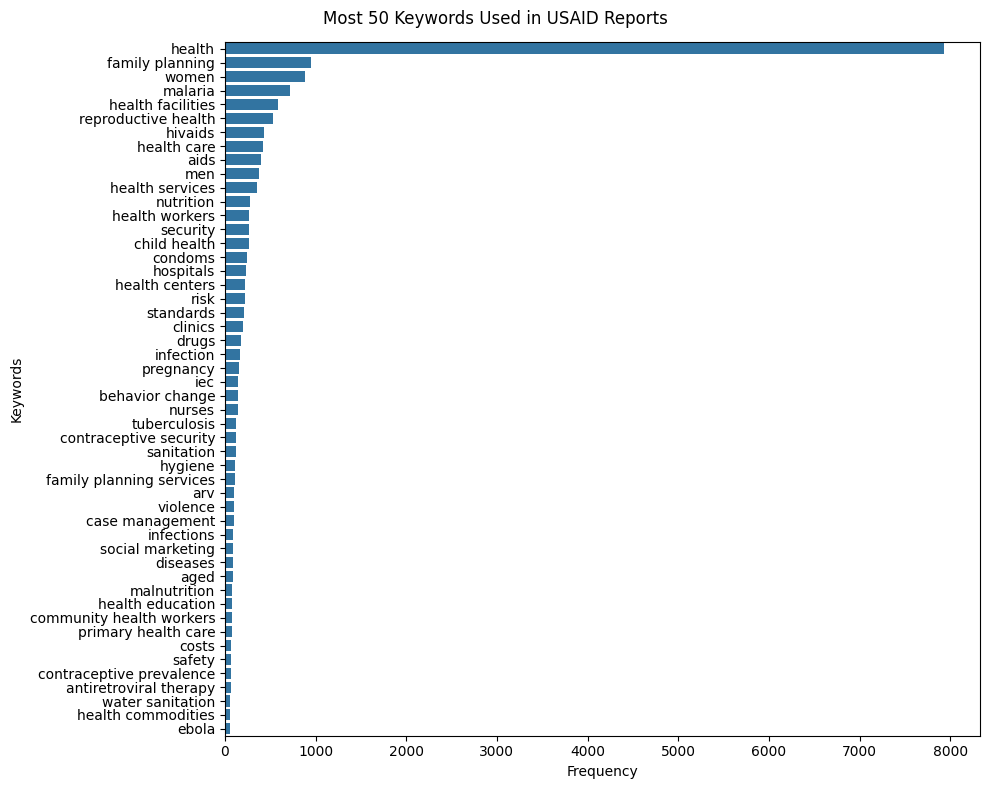

In [ ]:
# We filter the most 50 keywords used
top_50_df = ngram_frequency.sort_values(ascending=False).head(50).reset_index()
top_50_df.columns = ['Keyword', 'Count']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.barplot(x='Count', y='Keyword', data=top_50_df, orient='h')

ax.set_xlabel('Frequency')
ax.set_ylabel('Keywords')
fig.suptitle('Most 50 Keywords Used in USAID Reports')
plt.tight_layout()

To get the total frequency of keywords present per report we sum each row of the dataframe containing the frequencies of the n-grams.

We see that on average there are 31 different keywords present per report, and that the minimum of keywords found in a report is 7, which validates our hypothesis that all reports have a sufficient number of unique keywords.

In [ ]:
(df_ngram_frequency>0).sum(axis=1).describe()

count    99.000000
mean     29.828283
std       9.666944
min       7.000000
25%      23.000000
50%      31.000000
75%      36.000000
max      53.000000
dtype: float64

# Relative frequency keywords

We compute the relative frequency of politicized and non politicized keywords to see if both parties have a similar usage of politicized language.

In [ ]:
def get_keywords(txt:str, df_keywords:pd.DataFrame):
    '''
    Returns a list of strings which are the unique keywords found in a text.

    Parameters:
        txt: A string containing the text of a report.
        df_keywords: A pd.Dataframe object containing the Thesaurus keywords.

    Returns:
         A list of strings which contains the identified keywords in a text.
    '''
    return [
        row['Keyword_clean'] for index, row in df_keywords.iterrows()
        # we account only for keywords which do have a tensor score
        # the str case indicates a 'missing keyword'
        if txt.count(row['Keyword_clean']) > 0 \
        and not isinstance(row['tensor'], str)
    ]

In [ ]:
df['list_keywords'] = df['Text_clean'].apply(lambda x: get_keywords(x, df_keywords))

<ipython-input-46-31b3077935e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['list_keywords'] = df['Text_clean'].apply(lambda x: get_keywords(x, df_keywords))


We have a look at the output to verify it is as expected.

In [ ]:
df['list_keywords'].head()

0    [nutrition, medical equipment, medical supplie...
1    [tuberculosis, infections, iron, clinics, heal...
2    [malaria, infections, nutrition, nutritional s...
3    [malaria, nutrition, iron, sanitation, water s...
4    [tuberculosis, iron, hunger, clinics, nurses, ...
Name: list_keywords, dtype: object

We create a new column to determine the number of unique keywords extracted per report and analyse its statistical characteristics. The minimum number of unique keywords found is 9, which satisfies our hypothesis that a certain number of keywords are present in the reports and thus that we can compute a politicization score from them for each report. On average the reports use 34 different keywords from the Thesaurus keywords. The maximum number of keywords found is 56.

In [ ]:
df['nb_keywords'] = df['list_keywords'].apply(len)
df[['nb_keywords']].describe()

<ipython-input-48-2b8e2fc3edc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nb_keywords'] = df['list_keywords'].apply(len)


,nb_keywords
count,99.000000
mean,33.666667
std,9.796917
min,9.000000
25%,27.000000
50%,34.000000
75%,40.000000
max,56.000000


To compute the relative frequencies of politicized and non-politicized keywords we start by computing the frequency of the keywords by expert-labelled scores.

In [ ]:
frequencies = (
    df.explode('list_keywords')
    .merge(df_keywords, left_on='list_keywords', right_on='Keyword_clean')
    .groupby(['Presidential_Split', 'POLITICISED'])
    .size().unstack(fill_value=0)
)
print(frequencies)

POLITICISED            1    2    3
Presidential_Split                
D                    724  284  291
R                   1112  458  464


In [ ]:
frequencies.sum(axis=1)

Presidential_Split
D    1299
R    2034
dtype: int64

We calculate the relative frequencies for each of the three values of 'POLITICISED'.

In [ ]:
rel_frequencies = frequencies.div(frequencies.sum(axis=1), axis=0)
print(rel_frequencies)

POLITICISED                1         2         3
Presidential_Split                              
D                   0.557352  0.218630  0.224018
R                   0.546706  0.225172  0.228122


We distinguish between non-politicized keywords (score of 1) and politicized keywords (score of 2 and 3). We see that Democratic reports use 1% more non-politicized keywords than the Democratic reports. Overall non-politicized keywords are more represented (56% and 55%) than politiczed keywords (44% and 45%). Both parties have a similar quantity of politicized language.

In [ ]:
rel_frequencies = rel_frequencies.assign(
    **{'Non-Politicized': rel_frequencies[1],
        'Politicized': rel_frequencies[2] + rel_frequencies[3]}
)
print(rel_frequencies[['Non-Politicized', 'Politicized']].reset_index())

POLITICISED Presidential_Split  Non-Politicized  Politicized
0                            D         0.557352     0.442648
1                            R         0.546706     0.453294


# Evaluation keywords: Wilcoxon rank-sum test

## Verifiy statistical test conditions: Normality and Variance

To compare the distributions of politicized (score 2 and 3) and non-politiczed (score 1) keywords, we need to assess the normailty (Shapiro test) and variance ( Levene test) of both samples.

In [ ]:
def convert_tensor_to_float(value:float):
  '''
    Converts a the value of a tensor object to a float value.

    Parameters:
        value: A tensor object.

    Returns:
        value.item(): The value of the tensor object as a float.
  '''
  if isinstance(value, torch.Tensor):
        # we extract the numerical value of the tensor
        return value.item()
  return None

We sample from the keywords to obtain the non-politicized keywords (`scores_cat_1`) and the politicized keywords (`scores_cat_2_and_3`).

In [ ]:
# we apply conversion and filter out strings and None values
scores_cat_1 = [convert_tensor_to_float(score) for score in \
                df_keywords[df_keywords['POLITICISED'] == 1]['tensor'] if score]
scores_cat_2_and_3 = [convert_tensor_to_float(score) for score in \
                      df_keywords[df_keywords['POLITICISED'].isin([2, 3])]['tensor'] if score]

# we filter out None values which are the result of non-tensor data
# (non-tensor data are missing keywords )
scores_cat_1 = [score for score in scores_cat_1 if score is not None]
scores_cat_2_and_3 = [score for score in scores_cat_2_and_3 if score is not None]


We then perform the two tests on the distributions of both keyawords' category.

In [ ]:
# Normality: Shapiro-Wilk test
print("Normality test for non-politicized keywords (statistic, p-value):", \
      shapiro(scores_cat_1))
print("Normality test for politicized keywords(statistic, p-value):", \
      shapiro(scores_cat_2_and_3))

# Wqual variances: Levene's test
print("Equal variance test for keywords (statistic, p-value):", \
      levene(scores_cat_1, scores_cat_2_and_3))

Normality test for non-politicized keywords (statistic, p-value): ShapiroResult(statistic=0.8990100622177124, pvalue=5.09940946358256e-07)
Normality test for politicized keywords(statistic, p-value): ShapiroResult(statistic=0.7384800314903259, pvalue=1.8307176219423127e-08)
Equal variance test for keywords (statistic, p-value): LeveneResult(statistic=0.6550933381967406, pvalue=0.4194920862341268)



**Normality**:
The p-values for both non-politicized and politicized keywords are significantly less than 0.05, indicating that both groups significantly deviate from a normal distribution. The statistics being well below 1 also highlight this non-normality.

**Equal variances**:
The p-value for the Levene's test is greater than 0.05, suggesting that there is no significant evidence to reject the null hypothesis of equal variances between the two groups. This implies that the variances are statistically similar.

Since the Normality assumption is not respected for both populations, we need to perform a non-parametric test.

## Compute non parametric test

We compute both the Mannwhitney and the Wilcoxon ranksum test, which are non-parametric tests. In our paper we only discuss the Wilcoxon test since it contians more information, notably the sign of the statistical value, which indicates which group ranks higher in comparison to the other.

#### Mann-Whitney U test

In [ ]:
u_statistic, u_pvalue = mannwhitneyu(scores_cat_1, scores_cat_2_and_3)
print("Mann-Whitney U test (Statistic, P-value):", (u_statistic, u_pvalue))

Mann-Whitney U test (Statistic, P-value): (2163.5, 0.006021162359231355)


HO: There is no difference between the two distributions. The median (or mean rank) of the two distributions is equal.

Since p-value (0.006021) < 0.05, we reject the null hypothesis. This suggests there is a statistically significant difference in the rank distribution between the two groups. One group typically ranks higher than the other, which indicates a statistically significant difference in their medians.

*Problem*: we don't have a direction.

#### Wilcoxon rank-sum test

In [ ]:
print("Wilcoxon rank-sum test result:", ranksums(scores_cat_1, scores_cat_2_and_3))

Wilcoxon rank-sum test result: RanksumsResult(statistic=-2.748366774541038, pvalue=0.005989296937516556)


HO: There is no difference between the two distributions. The median (or mean rank) of the two distributions is equal.

The statistic of -2.748 is a measure of the difference between the ranks of the two groups being compared. The negative sign suggests that the ranks of the first group are generally lower than those of the second group. his coefficient means that non-politicized keywords are ranked 2.748 ranks lower on average than politicized keywords in their relative distributions. Since the p-value (0.00598) < 0.05, there is enough statistical significance to reject the null hypothesis. The observed differences between the distributions of politicized and non-politicized keywords indicate that our approach accurately identifies politicized topics by giving them higher scores.


# Evaluation reports: Spearman analysis

To determine the overall politicization score of a report, we average the score of all keywords it contains and we thereby extend our analysis from the politicization of individual words to the politicization of entire documents.

We compute three different Spearman tests to determine if our metric are correlated with the 'silver standard' scores

* Type-based score and Type-based silver score
* Token-based score and Token-based silver score
* Token-based score and Metadata-based silver score

## Type-based silver score

The type-based score is based on averaging the score of the keywords present in a text by their log-frequency.
We create two functions to generate the score and silver score of the reports:

* `get_politicization_score_type`
* `get_politicization_silver_score_type`

We then compute the correlation of our metric and the silver score.

In [ ]:
def get_politicization_score_type(text:str, df_keywords:pd.DataFrame):
    '''
    Returns a float as a politicization score for a certain string input.
    This score is type-based, meaning we compute it by averaging the scores of
    the keywords we identify in the text by their log-frequency. We use the
    politicization scores generated from keywords' contextualized embeddings
    to generate the score.

    Parameters:
        text: A string to compute politicization score from.

    Returns:
        A float between 1 and 0 representing the politicization silver score.
    '''
    cumulative_score = 0
    cumulative_count = 0
    for i, row in df_keywords.iterrows():
        count = text.count(row['Keyword_clean'])
        log_count = math.log1p(count)
        # We make sure the tensor is not a string, meaning it is not missing
        if count > 0 and not isinstance(row['tensor'], str):
            cumulative_score += log_count*row['tensor'].item()
            cumulative_count += log_count
    return cumulative_score/cumulative_count if cumulative_count > 0 else None


First we create our type-based politicization metric.

In [ ]:
df['score_type'] = df['Text_clean'].apply(lambda x: get_politicization_score_type(x, df_keywords))

<ipython-input-60-f1c375e39c50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_type'] = df['Text_clean'].apply(lambda x: get_politicization_score_type(x, df_keywords))


In [ ]:
def get_politicization_silver_score_type(text:str, df_keywords:pd.DataFrame):
    '''
    Returns a float as a politicization silver score for a certain string input.
    This score is type-based, meaning we compute it by averaging the scores of
    the keywords we identify in the text by their log-frequency. We use the
    expert-labelled politicization scores of the keywords to generate the silver
    score.

    Parameters:
        text: A string to compute politicization score from.

    Returns:
        A float between 1 and 0 representing the politicization silver score.
    '''
    cumulative_score = 0
    cumulative_count = 0
    for i, row in df_keywords.iterrows():
        count = text.count(row['Keyword_clean'])
        log_count = math.log1p(count)
        if count > 0 and not isinstance(row['POLITICISED'], str):
            cumulative_score += log_count*row['POLITICISED']
            cumulative_count += log_count
    return cumulative_score/cumulative_count if cumulative_count > 0 else None

The we compute our type-based silver score.

In [ ]:
df['silver_score_type'] = df['Text_clean'].apply(lambda x: get_politicization_silver_score_type(x, df_keywords))

<ipython-input-62-283ecf97cc40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['silver_score_type'] = df['Text_clean'].apply(lambda x: get_politicization_silver_score_type(x, df_keywords))


We then compute the Spearman correlation (non-parametric test) to test if there is a correlation between our metric and the 'silver standard' score.

In [ ]:
correlation, p_value = spearmanr(df['score_type'], df['silver_score_type'])

print("Spearman correlation coefficient:", correlation)
print("P-value:", p_value)

Spearman correlation coefficient: 0.4009400123685838
P-value: 3.9129775320129e-05


Small but statisticall significant correlation. Analysis developped in the paper.

## Token-based silver score

The token-based score is based on averaging the score of unique keywords present in a text.
We create two functions to generate the score and silver score of the reports:

* `get_politicization_score_token`
* `get_politicization_silver_score_token`

We then compute the correlation of our metric and the silver score.

In [ ]:
def get_politicization_score_reports_token(text:str, df_keywords: pd.DataFrame):
    '''
    Returns a float as a politicization score for a certain string input.
    This score is token-based, meaning we compute it by averaging the scores of
    the unique keywords we identify in the text. We use the
    politicization scores generated from keywords' contextualized embeddings
    to generate the score.

    Parameters:
        text: A string to compute politicization score from.

    Returns:
        A float between 1 and 0 representing the politicization silver score.
    '''
    cumulative_score = 0
    keyword_count = 0
    for index, row in df_keywords.iterrows():
        if text.count(row['Keyword_clean']) > 0:
            if not isinstance(row['tensor'], str):
                cumulative_score += row['tensor'].item()
                keyword_count += 1
    #print(keyword_count)
    return cumulative_score/keyword_count if keyword_count > 0 else None

First we create our token-based politicization metric.

In [ ]:
df['score_token'] = df['Text_clean'].apply(lambda x: get_politicization_score_reports_token(x, df_keywords))

<ipython-input-65-e0f34be0fde5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_token'] = df['Text_clean'].apply(lambda x: get_politicization_score_reports_token(x, df_keywords))


In [ ]:
def get_politicization_silver_score_reports_token(text:str, df_keywords: pd.DataFrame):
    '''
    Returns a float as a politicization silver score for a certain string input.
    This score is token-based, meaning we compute it by averaging the scores of
    the unique keywords we identify in the text. We use the expert-labelled
    politicization scores of the keywords to generate the silver score.

    Parameters:
        text: A string to compute politicization score from.

    Returns:
        A float between 1 and 0 representing the politicization silver score.
    '''
    cumulative_score = 0
    keyword_count = 0
    for index, row in df_keywords.iterrows():
        if text.count(row['Keyword_clean']) > 0:
            if not isinstance(row['POLITICISED'], str):
                cumulative_score += row['POLITICISED']
                keyword_count += 1
    return cumulative_score/keyword_count if keyword_count > 0 else None

Then we compute our type-based silver score.

In [ ]:
df['silver_score_token'] = df['Text_clean'].apply(lambda x: get_politicization_silver_score_reports_token(x, df_keywords))

<ipython-input-67-4663311c3e19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['silver_score_token'] = df['Text_clean'].apply(lambda x: get_politicization_silver_score_reports_token(x, df_keywords))


We then compute the Spearman correlation (non-parametric test) to test if there is a correlation between our metric and the 'silver standard' score.

In [ ]:
correlation, p_value = spearmanr(df['score_token'], df['silver_score_token'])

print("Spearman correlation coefficient:", correlation)
print("P-value:", p_value)

Spearman correlation coefficient: 0.23863639927984562
P-value: 0.017372778857075968


Small but statisticall significant correlation. Analysis developped in the paper.

## Metadata-based silver score

The metadata-based score is based on averaging the score of keywords present in the human-labelled list of terms related to each report (feature `USAID Thesaurus Term(s)`)
We create only one function to generate silver score of the reports (the score is the type-based):

* `get_politicization_silver_score_token`

We then compute the correlation of our metric and the silver score.

In [ ]:
def get_politicization_silver_score_reports_metadata(keywords:str, df_keywords:pd.DataFrame):
    '''
    Returns a float as a politicization silver score for a certain string input.
    This score is metadata-based, meaning we compute it by averaging the scores
    of the human-labelled keywords present in the feature `USAID Thesaurus Term(s)`.
    We use the expert-labelled  politicization scores of the keywords to
    generate the silver score.

    Parameters:
        text: A string to compute politicization score from.

    Returns:
        A float between 1 and 0 representing the politicization silver score.
    '''
    scores = [
        float(score)
        for keyword in keywords
        for score in df_keywords.loc[df_keywords['Keyword_clean'] == keyword, 'POLITICISED']
        if pd.notna(score) and score!='missing keywords'
    ]
    return np.mean(scores) if scores else np.nan

Here we compute the metadata-based silver score.

In [ ]:
df['silver_score_metadata'] = df['USAID_Thesaurus_Term(s)_Clean'].apply(lambda x: get_politicization_silver_score_reports_metadata(x, df_keywords))

<ipython-input-70-6523dd4ddb12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['silver_score_metadata'] = df['USAID_Thesaurus_Term(s)_Clean'].apply(lambda x: get_politicization_silver_score_reports_metadata(x, df_keywords))


We then compute the Spearman correlation (non-parametric test) to test if there is a correlation between our metric and the 'silver standard' score.

In [ ]:
correlation, p_value = spearmanr(df['score_token'], df['silver_score_metadata'])

print("Spearman Correlation Coefficient:", correlation)
print("P-value:", p_value)

Spearman Correlation Coefficient: 0.31433320461841224
P-value: 0.001531881184983872


Small but statisticall significant correlation. Analysis developped in the paper.